# Módulo 4 - Projeto 1: *support vector machines*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/456](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Instituto de Computação - Unicamp 2021

In [15]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, svm, metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier





import seaborn as sns

from IPython.display import display

In [2]:
np.random.seed(1082141)
sns.set()

## Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [3]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

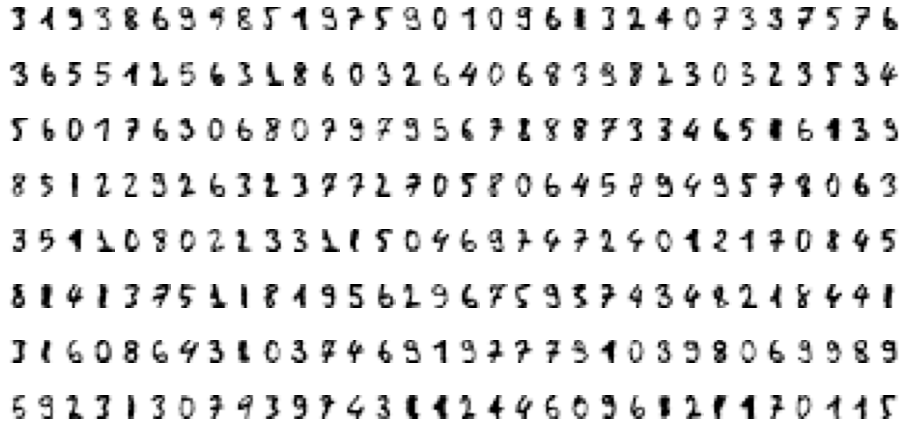

In [4]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error

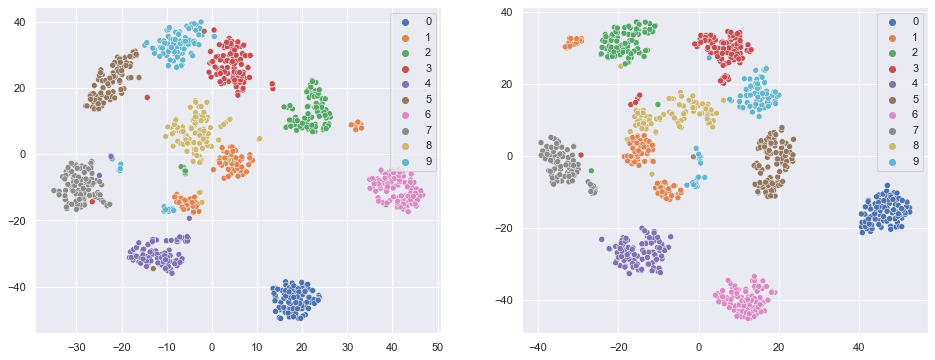

In [5]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


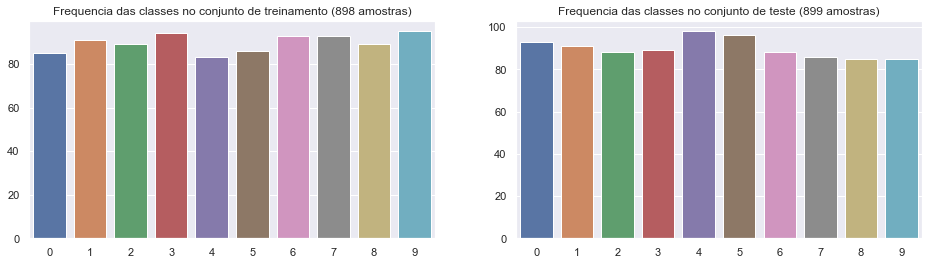

In [6]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos

**Atividade (3 pts):** defina e treine uma máquina de vetor de suporte com diferentes tipos de kernel, utilizando o scikit-learn. Avalie os diversos tipos de kernel e seus respectivos parâmetros com relação a qualidade da solução. Você deve separar uma parte do conjunto de treino para fazer a validação cruzada. Não utilize o conjunto de teste ainda.

In [7]:
#Criando um conjunto validação
x = x_train
y = y_train
X_train, x_val, Y_train, y_val = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em validação: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')
      


amostras em treino: 898
amostras em validação: 899
número de características: 64
número de classes: 10



In [8]:
def balanced_accuracy(model, model_name: str) -> None:

    print(model_name)

    predicted_train= model.predict(X_train)
    balanced_accuracy_train= balanced_accuracy_score(Y_train, predicted_train)
    
    print(f"acurácia balanceada(treino): {balanced_accuracy_train}")

    predicted_validation = model.predict(x_val)
    balanced_accuracy_validation = balanced_accuracy_score(y_val,predicted_validation)
    print(f"acurácia balanceada(validação): {balanced_accuracy_validation}")

    predicted_validation = model.predict(x_test)
    balanced_accuracy_validation = balanced_accuracy_score(y_test,predicted_validation)
    print(f"acurácia balanceada(teste): {balanced_accuracy_validation}\n")


def show_metrics(model, model_name: str, prediction) -> None:
    balanced_accuracy(model=model,model_name=model_name)
    print(f"{metrics.classification_report(y_test, prediction)}\n")

    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, prediction)
    disp.figure_.suptitle("Matriz de confusão")
    print(f"Matriz de confusão:\n{disp.confusion_matrix}")
    plt.show()

In [13]:
# Usando grid search para definir os melhores parametros
kernel = ["linear","poly","rbf","sigmoid"]
C = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
svc = svm.SVC()
clf = GridSearchCV(estimator = svc, param_grid = parameters, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)


Fitting 5 folds for each of 784 candidates, totalling 3920 fits
{'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}


In [144]:
# ATENÇÃO: TESTAMOS 20k FITS, PODE DAR ESTOURO DE MEMORIA
# Refinando
C = np.arange(1,5,0.1)
gamma = np.logspace(-3, -2,100)

parameters = {'C': C, 'gamma': gamma}
svc = svm.SVC(kernel = "rbf")
clf = GridSearchCV(estimator = svc, param_grid = parameters, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
{'C': 1.0, 'gamma': 0.0019179102616724887}


### Avaliando o modelo treinado

**Atividade (2 pts):** avalie o seu melhor modelo treinado no item anterior sobre o conjunto de teste previamente separado. Reporte a acurácia média, a matriz de confusão e outras métricas que achar válido.

SVM RBF C: 2.0 gamma: 0.001
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9845427224968908
acurácia balanceada(teste): 0.9804704259944094

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        93
           1       0.99      1.00      0.99        91
           2       1.00      0.99      0.99        88
           3       0.98      0.99      0.98        89
           4       0.99      1.00      0.99        98
           5       0.98      1.00      0.99        96
           6       1.00      0.97      0.98        88
           7       0.99      0.95      0.97        86
           8       0.94      0.98      0.96        85
           9       0.94      0.95      0.95        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899


Matriz de confusão:
[[91  0  0  1  1  0  0  0  0  0]
 [ 0 91  0  0  0  0  0  0  

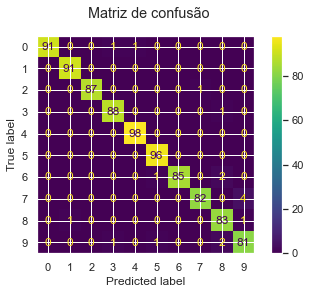

In [16]:
best_classifier = svm.SVC(gamma=0.002, C=1, kernel="rbf")
best_classifier.fit(X_train, Y_train)
prediction = best_classifier.predict(x_test)

show_metrics(model=best_classifier, model_name="SVM RBF C: 2.0 gamma: 0.001", prediction=prediction)



**Atividade (4 pts):** treine dois ou mais classificadores (Random forest, logistic regression, etc.) e reporte o suas respectivas métricas sobre as porções de validação separadas (acurácia, acurácia balanceada, precision, etc). Compare seus melhores classificadores com os resultados da SVM no conjunto de teste. 


SVM RBF C: 2.0 gamma: 0.001
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9845427224968908
acurácia balanceada(teste): 0.9804704259944094

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        93
           1       0.99      1.00      0.99        91
           2       1.00      0.99      0.99        88
           3       0.98      0.99      0.98        89
           4       0.99      1.00      0.99        98
           5       0.98      1.00      0.99        96
           6       1.00      0.97      0.98        88
           7       0.99      0.95      0.97        86
           8       0.94      0.98      0.96        85
           9       0.94      0.95      0.95        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899


Matriz de confusão:
[[91  0  0  1  1  0  0  0  0  0]
 [ 0 91  0  0  0  0  0  0  

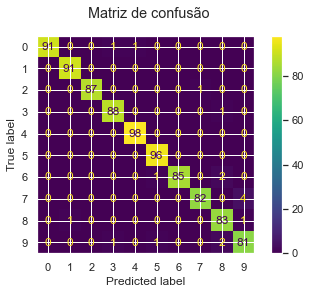

In [17]:
#### SVM ######
best_classifier = svm.SVC(gamma=0.002, C=1, kernel="rbf")
best_classifier.fit(X_train, Y_train)
predicted = best_classifier.predict(x_test)



show_metrics(model=best_classifier, model_name="SVM RBF C: 2.0 gamma: 0.001", prediction=prediction)



In [18]:
#### Decision Tree ####
# Usando grid search para definir os melhores parametros
criterion = ["gini", "entropy"]
max_depth =[1,2,4,8,16,32,64,None]
min_samples_leaf = np.arange(1,20,1)
max_features = ["auto", "sqrt", "log2", None]

parameters = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,'max_features':max_features}
model = DecisionTreeClassifier()
clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)

Fitting 5 folds for each of 1216 candidates, totalling 6080 fits
{'criterion': 'entropy', 'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1}


Decision
acurácia balanceada(treino): 0.9697847317038295
acurácia balanceada(validação): 0.8116093363149472
acurácia balanceada(teste): 0.7962498606913837

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        93
           1       0.60      0.71      0.65        91
           2       0.80      0.80      0.80        88
           3       0.75      0.89      0.81        89
           4       0.76      0.70      0.73        98
           5       0.80      0.73      0.76        96
           6       0.97      0.86      0.92        88
           7       0.92      0.80      0.86        86
           8       0.66      0.76      0.71        85
           9       0.90      0.78      0.84        85

    accuracy                           0.80       899
   macro avg       0.81      0.80      0.80       899
weighted avg       0.81      0.80      0.80       899


Matriz de confusão:
[[86  0  0  0  4  2  0  0  1  0]
 [ 0 65  8  8  3  2  1  1  1  2

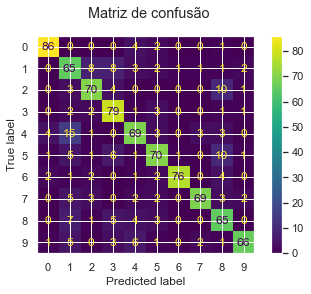

In [231]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=32, min_samples_leaf=2, max_features=None)
tree.fit(X_train, Y_train)
tree_predicted = tree.predict(x_test)
show_metrics(model=tree, model_name="Decision", prediction=tree_predicted)


In [164]:
##### KNN #####
# Usando grid search para definir os melhores parametros
p = [1,2]
n_neighbors = list(range(1,30))
leaf_size = list(range(1,50))

parameters = {'n_neighbors': n_neighbors, 'p': p, 'leaf_size': leaf_size}
knn = KNeighborsClassifier()
clf = GridSearchCV(estimator = knn, param_grid = parameters, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)


Fitting 5 folds for each of 2842 candidates, totalling 14210 fits
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}


KNN
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9771055859899869
acurácia balanceada(teste): 0.9819550198147553

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        93
           1       0.96      0.99      0.97        91
           2       0.99      0.98      0.98        88
           3       0.97      1.00      0.98        89
           4       0.99      0.99      0.99        98
           5       1.00      0.98      0.99        96
           6       0.99      0.98      0.98        88
           7       0.99      0.99      0.99        86
           8       0.96      0.96      0.96        85
           9       0.98      0.96      0.97        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899


Matriz de confusão:
[[92  0  0  0  1  0  0  0  0  0]
 [ 0 90  0  0  0  0  0  0  1  0]
 [ 0  0 86  1  0  

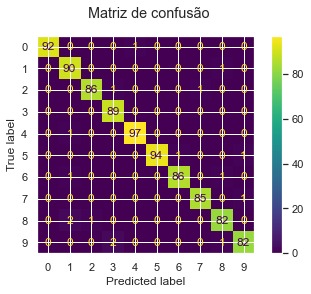

In [195]:
knn = KNeighborsClassifier(leaf_size=1,n_neighbors=1,p=2)
knn.fit(X_train, Y_train)
knn_predicted = knn.predict(x_test)

show_metrics(model=knn, model_name="KNN", prediction=knn_predicted)


In [26]:
#### Random Forest ####
# Usando grid search para definir o melhor intervalo para random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 150, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
random_forest = RandomForestClassifier()
clf = GridSearchCV(estimator = random_forest, param_grid = random_grid, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)



Fitting 5 folds for each of 864 candidates, totalling 4320 fits
{'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


Random Forest
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9709952570588731
acurácia balanceada(teste): 0.958966316517062

Random
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9709952570588731
acurácia balanceada(teste): 0.958966316517062

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        93
           1       0.96      0.98      0.97        91
           2       0.99      0.97      0.98        88
           3       0.94      0.98      0.96        89
           4       0.96      0.99      0.97        98
           5       0.98      0.98      0.98        96
           6       0.98      0.94      0.96        88
           7       0.97      0.91      0.94        86
           8       0.93      0.93      0.93        85
           9       0.91      0.94      0.92        85

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg 

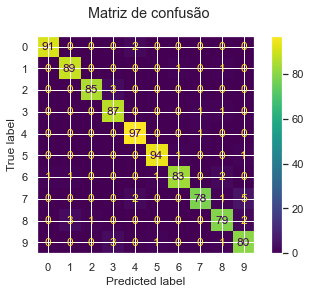

In [30]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=150, max_features="auto", min_samples_leaf=1,min_samples_split=2)
random_forest.fit(X_train, Y_train)
random_forest_predicted = random_forest.predict(x_test)
show_metrics(model=random_forest, model_name="Random Forest", prediction=random_forest_predicted)



In [34]:
C = [10**(-10), 10**(-5), 10 **(-2), 10 **(-1), 1]
penalty = ["l1", "l2"]


# parameters = {'C': C, 'penalty': penalty}
parameters = {'C': C }
# parameters = {'penalty': penalty}
model = LogisticRegression()
clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv =5, n_jobs = -1, verbose = 1)
clf.fit(X_train, Y_train)
print(clf.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.01}


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9508815248347842
acurácia balanceada(teste): 0.936882000024192

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        93
           1       0.88      0.92      0.90        91
           2       0.96      0.97      0.96        88
           3       0.88      0.94      0.91        89
           4       0.97      0.97      0.97        98
           5       0.93      0.93      0.93        96
           6       0.98      0.94      0.96        88
           7       1.00      0.90      0.94        86
           8       0.88      0.88      0.88        85
           9       0.92      0.93      0.92        85

    accuracy                           0.94       899
   macro avg       0.94      0.94      0.94       899
weighted avg       0.94      0.94      0.94       899


Matriz de confusão:
[[92  0  1  0  0  0  0  0  0  0]
 [ 0 84  0  2  0  0  0  0  3  2]
 [ 0  3 85  0  0  0

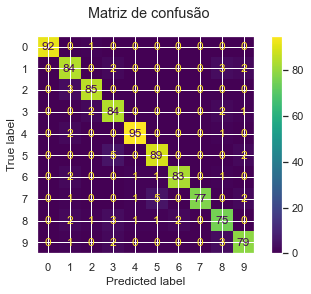

In [36]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)
logistic_regression_predicted = knn.predict(x_test)

show_metrics(model=logistic_regression, model_name="KNN", prediction=logistic_regression_predicted)

**Pergunta (1pt):** qual classificador apresentou os melhores resultados? Qual critério você utilizou para definir sua escolha? Discuta.

In [157]:
Para este problema, o KNN foi o que apresentou a melhor acurácia balanceada. 


Random Forest
acurácia balanceada(treino): 0.9163704558149078
acurácia balanceada(validação): 0.7997604238851327
acurácia balanceada(teste): 0.767335155535562

MLP
acurácia balanceada(treino): 1.0
acurácia balanceada(validação): 0.9665924119378845
acurácia balanceada(teste): 0.9360904831816443

Adaboost
acurácia balanceada(treino): 0.2933010214717532
acurácia balanceada(validação): 0.2830048000779708
acurácia balanceada(teste): 0.24736263866783856

Gaussian
acurácia balanceada(treino): 0.8618013101380138
acurácia balanceada(validação): 0.8181298089967672
acurácia balanceada(teste): 0.8156758681901198



/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
